### Chapter2. Cross-validation

在建立自己的机器学习模型之前，必须要知道什么是交叉验证，以及如何选择合适的交叉验证方法。

##### 2.1 读入数据

In [2]:
import pandas as pd

In [20]:
# 数据地址见本项目README.md
df = pd.read_csv("../Dataset/winequality-red.csv")

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [21]:
# 数据集仅包含六个质量值的类型。因此，我们将映射从 0 到 5。
quality_mapping = {
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}

# 使用pandas中的map方法将数值做映射
df.loc[:, "quality"] = df.quality.map(quality_mapping)

##### 2.2 分割数据集

In [23]:
# 数据集有1599个样本，现在将其中的1000个为训练集。
# shuffling df  .sample采样df中所有行(frac=100%)  .reset_index 重置下标点
df = df.sample(frac=1).reset_index(drop=True)

df_train = df.head(1000)

df_test = df.tail(599)

##### 2.3 使用决策树分类

In [29]:
from sklearn import tree
from sklearn import metrics

# 初始化决策树，最大深度为3
clf = tree.DecisionTreeClassifier(max_depth=7)

# 选择特征
cols = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# 训练
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(max_depth=7)

##### 2.4 测试分类器的精确度

In [30]:
train_predictions = clf.predict(df_train[cols])

test_predictions = clf.predict(df_test[cols])

train_accuracy = metrics.accuracy_score(
    df_train.quality, train_predictions
)
test_accuracy = metrics.accuracy_score(
    df_test.quality, test_predictions
)

print(f"训练集精确度:{train_accuracy}  测试机精确度:{test_accuracy}")

训练集精确度:0.723  测试机精确度:0.5959933222036727


##### 2.5 决策树深度参数对模型影响可视化

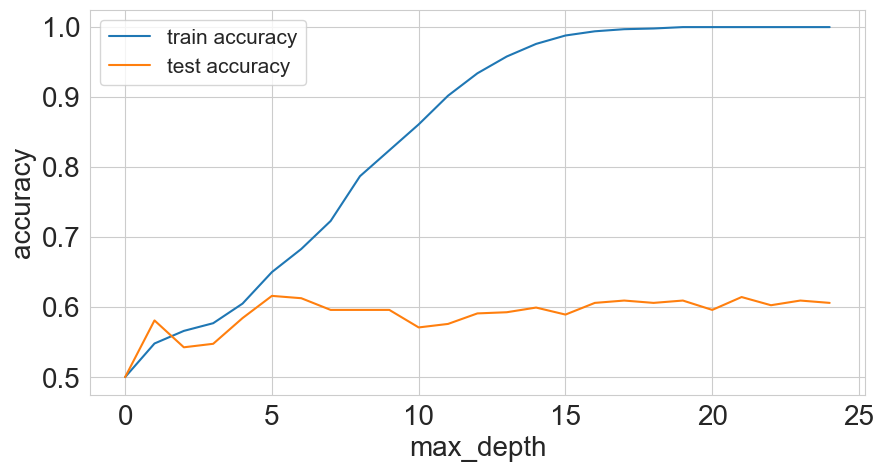

In [46]:
from sklearn import tree
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc("xtick", labelsize=20)
matplotlib.rc("ytick", labelsize=20)

%matplotlib inline

# 初始化精确度列表
train_accuracies = [0.5]
test_accuracies = [0.5]

for depth in range(1, 25):
    clf = tree.DecisionTreeClassifier(max_depth = depth)

    cols = [
        'fixed acidity',
        'volatile acidity',
         'citric acid',
        'residual sugar',
        'chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density',
        'pH',
        'sulphates',
        'alcohol'
    ]
    # fit the model on given features
    clf.fit(df_train[cols], df_train.quality)
    # create training & test predictions
    train_predictions = clf.predict(df_train[cols])
    test_predictions = clf.predict(df_test[cols])
    
    # calculate training & test accuracies
    train_accuracy = metrics.accuracy_score(
        df_train.quality, train_predictions
    )
    test_accuracy = metrics.accuracy_score(
        df_test.quality, test_predictions
    )

    # append accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# create two plots using matplotlib
# and seaborn
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.legend(loc="upper left", prop={'size': 15})
plt.xticks(range(0, 26, 5))
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.show()

上图能看出出现了严重的过拟合现象

##### 2.6 K-fold

In [47]:
import pandas as pd
from sklearn import model_selection

def K_fold(dataset_csv, save_csv, n_splits):
    df = pd.read_csv(dataset_csv)

    # 新建一列kfold
    df["kfold"] = -1

    # 打乱数据
    df = df.sample(frac=1).reset_index(drop=True)

    # 初始化kfold类
    kf = model_selection.KFold(n_splits=n_splits)

    for fold, (trn_, val_) in enumerate(kf.split(X=df)):
        df.loc[val_, 'kfold'] = fold
    
    df.to_csv(save_csv, index = False)
    

##### 2.7 Stratified K-fold

K-fold基于随机打乱数据集然后做fold， stratified K-fold则能保证每个fold中的正样本与负样本比例保持一致，所以每个fold得到的结果会是一样的。

In [ ]:
def stratified_K_fold(dataset_csv, save_csv, n_splits, y):
    df = pd.read_csv(dataset_csv)

    # 新建一列kfold
    df["kfold"] = -1

    # 打乱数据
    df = df.sample(frac=1).reset_index(drop=True)

    # 初始化kfold类  
    kf = model_selection.StratifiedKFold(n_splits=n_splits)  #<= 修改这里

    for fold, (trn_, val_) in enumerate(kf.split(X=df, y = y)):  #<= 修改这里
        df.loc[val_, 'kfold'] = fold
    
    df.to_csv(save_csv, index = False)

##### 2.8 红酒数据集数据分布

Text(0, 0.5, 'count')

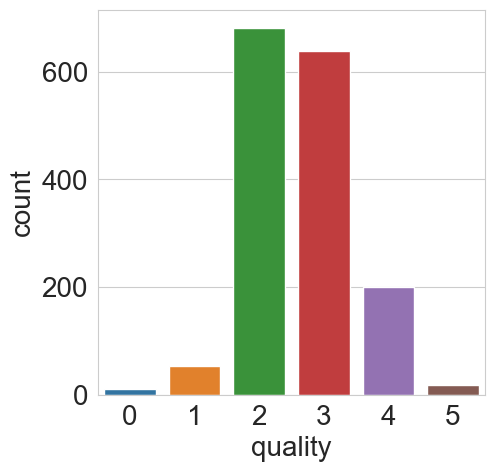

In [57]:
plt.figure(figsize=(5, 5))
b = sns.countplot(x="quality", data=df)
b.set_xlabel("quality", fontsize=20)
b.set_ylabel("count", fontsize=20)

##### 2.9 回归问题的Stratified K-fold

In [21]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn import model_selection

def create_folds(data):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)

    num_bins = np.floor(1 + np.log2(len(data)))

    data.loc[:, "bins"] = pd.cut(
        data["target"], bins=int(num_bins), labels=False
    )

    kf = model_selection.StratifiedKFold(n_splits=5)

    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    data = data.drop("bins", axis=1)

    return data

X, y = datasets.make_regression(
    n_samples = 15000, n_features = 100, n_targets = 1
)

df = pd.DataFrame(
    X,
    columns = [f"f_{i}" for i in range(X.shape[1])]
)
df.loc[:, "target"] = y

df = create_folds(df)